In [1]:
import os
import ray
import re
import random
import datetime

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from util import *
from estimator import *
from evaluator import run_grid_search

os.environ.pop('http_proxy', None)

'http://192.168.0.1:8123'

### Parse Web of Science data (https://data.mendeley.com/datasets/9rw3vkcfy4/5)

In [2]:
input_file = Path('./data/WOS46985/X.txt')
target_file = Path('./data/WOS46985/YL1.txt')
results_folder = Path('./data/WOS46985_RESULTS')
processed_data_file = Path('./data/WOS46985_RESULTS/data.json')

class_labels = ["Computer Science","Electrical Engineering", "Psychology", "Mechanical Engineering", "Civil Engineering", "Medical Science", "Biochemistry", "N/A"]
class_labels_to_id = {c_name: i for i, c_name in enumerate(class_labels)}
dataset = 'WOS46985'
def parse_WOS46985(input_file, target_file):
    
    data = []

    # Read input sentences
    with open(input_file, 'r') as f_input:
        inputs = f_input.read().splitlines()

    # Read target classes
    with open(target_file, 'r') as f_class:
        classes = f_class.read().splitlines()

    # Ensure the number of inputs and classes match
    if len(inputs) != len(classes):
        raise ValueError("Number of input sentences does not match number of classes")

    # Create list of dictionaries
    for i, (inp, cls) in enumerate(zip(inputs, classes)):
        sample = {
            "id": i + 1, # Using 1-based index for id
            "input": inp,
            "class": class_labels[int(cls)]
        }
        data.append(sample)

    return data


def balance_dataset(class_labels, samples, total_samples):
    # Shuffle the samples
    random.shuffle(samples)
    
    n_samples_per_class = total_samples // len(class_labels)
    balanced_dataset = []
    class_count = {label: 0 for label in class_labels}
    
    remaining_samples = []
    
    for sample in samples:
        label = sample['class']
        if class_count[label] < n_samples_per_class:
            balanced_dataset.append(sample)
            class_count[label] += 1
        else:
            remaining_samples.append(sample)
    
    # If we still need more samples to reach total_samples, randomly sample from remaining samples
    while len(balanced_dataset) < total_samples and remaining_samples:
        random_sample = random.choice(remaining_samples)
        balanced_dataset.append(random_sample)
        remaining_samples.remove(random_sample)

    # Now, extract one sample per class from the remaining samples
    one_sample_per_class = []
    for label in class_labels:
        for s in remaining_samples:
            if s['class'] == label:
                one_sample_per_class.append(s)
                break
                
    return balanced_dataset[:total_samples], one_sample_per_class  # Ensure exactly total_samples in the output


random.seed(42)

n_samples = 2000

if not os.path.exists(processed_data_file):
    data_list, one_shot_examples = balance_dataset(class_labels[:-1], parse_WOS46985(input_file, target_file), n_samples)  # do not count NA

    # Serialize the dictionary to a JSON string
    json_data = json.dumps((data_list, one_shot_examples))
    
    # Write the JSON string to a file
    with open(processed_data_file, 'w') as f:
        f.write(json_data)
else:
    with open(processed_data_file, 'r') as f:
        data_list, one_shot_examples = json.load(f)

sample_ids = [s["id"] for s in data_list]

def class_extractor_fun(text):
    # we might want to check if more than a word is returned, but does not seem strictly necessary
    for l in class_labels:
        if l.lower() in text.lower():
            return l
    # if no label has been found
    return "N/A"

In [3]:
s_id = 1
print(data_list[s_id]['input'])
print(data_list[s_id]['class'])

for s in one_shot_examples:
    print(s['class'])

Nanoscale spacing between the plasma membrane and the underlying cortical actin cytoskeleton profoundly modulates cellular morphology, mechanics, and function. Measuring this distance has been a key challenge in cell biology. Current methods for dissecting the nanoscale spacing either limit themselves to complex survey design using fixed samples or rely on diffraction-limited fluorescence imaging whose spatial resolution is insufficient to quantify distances on the nanoscale. Using dual-color super-resolution STED (stimulated-emission-depletion) microscopy, we here overcome this challenge and accurately measure the density distribution of the cortical actin cytoskeleton and the distance between the actin cortex and the membrane in live Jurkat T-cells. We found an asymmetric cortical actin density distribution with a mean width of 230 (+105/-125) nm. The spatial distances measured between the maximum density peaks of the cortex and the membrane were bi-modally distributed with mean valu

## Run a grid search over parameters

In [4]:
question_to_rewrite = "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry."

prompt_simple = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, and Biochemistry.\nHere is the text: {summary}"]    
]

prompt_instruct = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: \n- Computer Science: The study of algorithms, data structures, and software design to solve complex problems using computational systems. \n- Electrical Engineering: Focuses on the design, development, and testing of electrical equipment, from microchips to power station generators. \n- Psychology: The scientific study of the mind and behavior, exploring how people think, feel, and interact.\n- Mechanical Engineering: Involves the design, analysis, and manufacturing of mechanical systems, ranging from small components to large machinery.\n- Civil Engineering: Deals with the design, construction, and maintenance of infrastructure projects such as bridges, roads, and buildings.\n- Medical Science: Encompasses the study and research of the human body and its functions, aiming to improve health and treat diseases.\n- Biochemistry: The study of chemical processes within and related to living organisms, merging biology and chemistry to understand cellular and molecular mechanisms.\nHere is the text: {summary}"]    
]

prompt_fewshot = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, and Biochemistry.\n"]    
]
prompt_fewshot[1][1] = prompt_fewshot[1][1] + "Here are a few examples:\n"
for s in one_shot_examples:
    prompt_fewshot[1][1] = prompt_fewshot[1][1] + f"Class {s['class']}: {s['input']}\n" 
prompt_fewshot[1][1] = prompt_fewshot[1][1] + "\nHere is the text: {summary}"

prompt_types = {"simple": prompt_simple,
                "instruct": prompt_instruct,
                "fewshot": prompt_fewshot,
                }

print(prompt_instruct)

llms = ['llama3', 'mixtral']#, 'gpt-3.5', 'gpt-4o']
Qs = [30] # number of equivalent but alternative questions compared to original question
temp_questions = [0.]#list(np.arange(0., 1.25, 0.25))  # temperature of the LLM used to produce questions
# temp_questions = list(np.arange(0., 0.25, 0.25))  # temperature of the LLM used to produce questions
As = [1] # number of alternative answers for each questions
temp_answers =  [0.] # list(np.arange(0., 1.5, 0.25))  # temperature of the LLM used to produce answers

samples = data_list
n_samples = len(samples)
print(f'Num test examples is {len(samples)}')

[['system', 'You are a text classifier.'], ['user', 'Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: \n- Computer Science: The study of algorithms, data structures, and software design to solve complex problems using computational systems. \n- Electrical Engineering: Focuses on the design, development, and testing of electrical equipment, from microchips to power station generators. \n- Psychology: The scientific study of the mind and behavior, exploring how people think, feel, and interact.\n- Mechanical Engineering: Involves the design, analysis, and manufacturing of mechanical systems, ranging from small components to large machinery.\n- Civil Engineering: Deals with the design, construction, and maintenance of infrastructure projects such as bridges, roads, and buildings.\n- Medical Science:

In [ ]:
run_grid_search(samples,
                llms,
                prompt_types,
                Qs,
                temp_questions,
                question_to_rewrite,
                As,
                temp_answers,
                class_labels,
                class_extractor_fun,
                results_folder)

2024-08-04 08:24:56,910	INFO worker.py:1621 -- Started a local Ray instance.


Skipping test 40098_llama3_30_1_0.0_0.0
Skipping test 23329_llama3_30_1_0.0_0.0
Skipping test 7103_llama3_30_1_0.0_0.0
Skipping test 25733_llama3_30_1_0.0_0.0
Skipping test 9237_llama3_30_1_0.0_0.0
Skipping test 31983_llama3_30_1_0.0_0.0
Skipping test 23112_llama3_30_1_0.0_0.0
Skipping test 40776_llama3_30_1_0.0_0.0
Skipping test 19185_llama3_30_1_0.0_0.0
Skipping test 21431_llama3_30_1_0.0_0.0
Skipping test 46951_llama3_30_1_0.0_0.0
Skipping test 44798_llama3_30_1_0.0_0.0
Skipping test 22040_llama3_30_1_0.0_0.0
Skipping test 25442_llama3_30_1_0.0_0.0
Skipping test 29631_llama3_30_1_0.0_0.0
Skipping test 31076_llama3_30_1_0.0_0.0
Skipping test 39395_llama3_30_1_0.0_0.0
Skipping test 6773_llama3_30_1_0.0_0.0
Skipping test 14644_llama3_30_1_0.0_0.0
Skipping test 28649_llama3_30_1_0.0_0.0
Skipping test 19437_llama3_30_1_0.0_0.0
Skipping test 21550_llama3_30_1_0.0_0.0
Skipping test 33888_llama3_30_1_0.0_0.0
Skipping test 15146_llama3_30_1_0.0_0.0
Skipping test 7237_llama3_30_1_0.0_0.0
Skip

2024-08-04 11:18:09,499	INFO worker.py:1621 -- Started a local Ray instance.


Reusing same prompt variants from "simple" approach...
Job 40098_llama3_30_1_0.0_0.0 submitted
Job 23329_llama3_30_1_0.0_0.0 submitted
Job 7103_llama3_30_1_0.0_0.0 submitted
Job 25733_llama3_30_1_0.0_0.0 submitted
Job 9237_llama3_30_1_0.0_0.0 submitted
Job 31983_llama3_30_1_0.0_0.0 submitted
Job 23112_llama3_30_1_0.0_0.0 submitted
Job 40776_llama3_30_1_0.0_0.0 submitted
Job 19185_llama3_30_1_0.0_0.0 submitted
Job 21431_llama3_30_1_0.0_0.0 submitted
Job 46951_llama3_30_1_0.0_0.0 submitted
Job 44798_llama3_30_1_0.0_0.0 submitted
Job 22040_llama3_30_1_0.0_0.0 submitted
Job 25442_llama3_30_1_0.0_0.0 submitted
Job 29631_llama3_30_1_0.0_0.0 submitted
Job 31076_llama3_30_1_0.0_0.0 submitted
Job 39395_llama3_30_1_0.0_0.0 submitted
Job 6773_llama3_30_1_0.0_0.0 submitted
Job 14644_llama3_30_1_0.0_0.0 submitted
Job 28649_llama3_30_1_0.0_0.0 submitted
Job 19437_llama3_30_1_0.0_0.0 submitted
Job 21550_llama3_30_1_0.0_0.0 submitted
Job 33888_llama3_30_1_0.0_0.0 submitted
Job 15146_llama3_30_1_0.0_0.

In [ ]:
plot_TVD_info(sample_ids,
              prompt_types,
              llms,
              Qs,
              temp_questions,
              As,
              temp_answers,
              class_labels,
              results_folder)

In [ ]:
plot_questions_vs_predicted_distribution(sample_ids,
                                        prompt_types,
                                        llms,
                                        Qs,
                                        temp_questions,
                                        As,
                                        temp_answers,
                                        class_labels,
                                        results_folder)

In [ ]:
plot_questions_vs_class_sensitivity(sample_ids,
                               prompt_types,
                               llms,
                               Qs,
                               temp_questions,
                               As,
                               temp_answers,
                               class_labels,
                               results_folder)

In [5]:
for llm in ['llama3', 'mixtral']:
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        Q = 30
        A = 1  # MUST stay 1
        temp_question = 0.
        temp_answer = 0.
        max_value = 1
        
        print_classification_scores(sample_ids,
                                    prompt_type,
                                    llm,
                                    Q,
                                    temp_question,
                                    A,
                                    temp_answer,
                                    class_labels,
                                    results_folder)

llama3 simple
Global scores, accuracy: 0.6265, micro f1-score: 0.6265, macro f1-score: 0.5556344251746328
Standard deviation of microf1 score: 0.008898954370536389
llama3 instruct
Global scores, accuracy: 0.6245, micro f1-score: 0.6245, macro f1-score: 0.5492617169327373
Standard deviation of microf1 score: 0.008564153327809002
llama3 fewshot
Global scores, accuracy: 0.58, micro f1-score: 0.58, macro f1-score: 0.5117358870137116
Standard deviation of microf1 score: 0.008206789194861109
mixtral simple
Global scores, accuracy: 0.606, micro f1-score: 0.606, macro f1-score: 0.5293282153887925
Standard deviation of microf1 score: 0.019707337888884607
mixtral instruct
Global scores, accuracy: 0.5985, micro f1-score: 0.5985, macro f1-score: 0.5230611345877665
Standard deviation of microf1 score: 0.013379669486035741
mixtral fewshot
Global scores, accuracy: 0.5655, micro f1-score: 0.5655, macro f1-score: 0.4908702458663067
Standard deviation of microf1 score: 0.028796103131423112
gpt-3.5 simpl

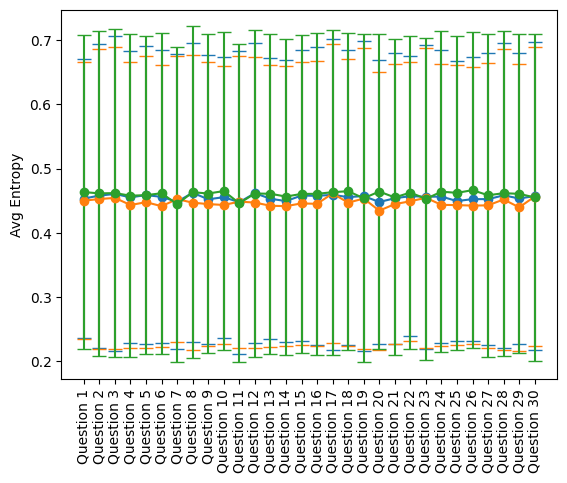

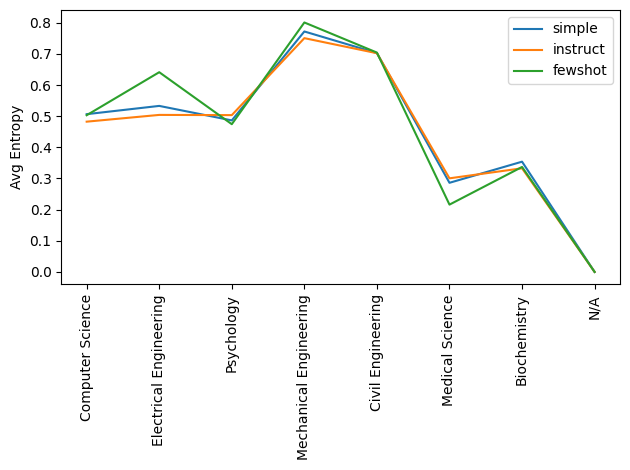

KeyboardInterrupt: 

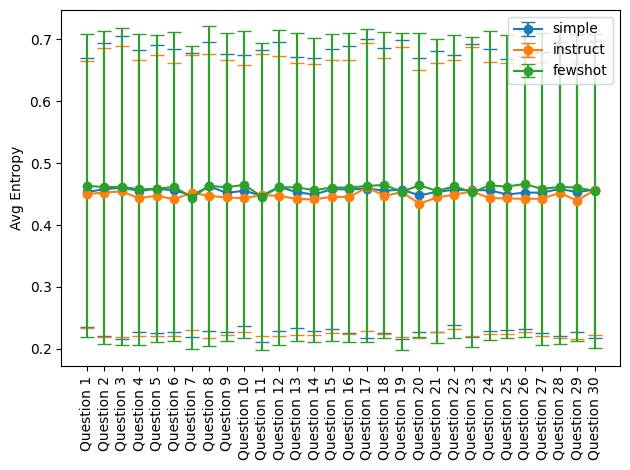

In [6]:
plot_avg_sensitivity(sample_ids,
                 prompt_types,
                 ['llama3'],
                 Qs,
                 [0.],
                 As,
                 temp_answers,
                 class_labels,
                 results_folder)

llama3 simple
Avg Entropy over samples: 0.04301167643058448,Std (over questions): 0.1031016583752917
llama3 instruct
Avg Entropy over samples: 0.03430407375867527,Std (over questions): 0.09162318603590693
llama3 fewshot
Avg Entropy over samples: 0.03529279992603117,Std (over questions): 0.09255717750375032


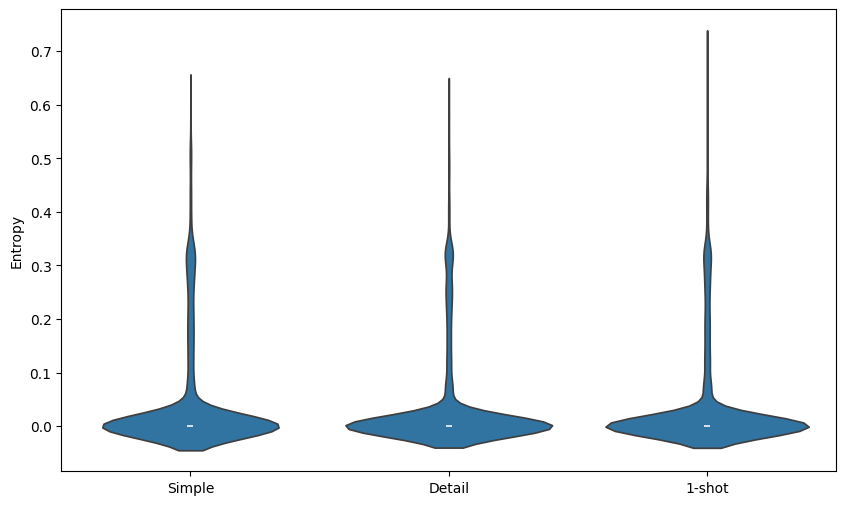

mixtral simple
Avg Entropy over samples: 0.11274011631105696,Std (over questions): 0.16450686009253637
mixtral instruct
Avg Entropy over samples: 0.123732284923406,Std (over questions): 0.1716666964153825
mixtral fewshot
Avg Entropy over samples: 0.14240431133558581,Std (over questions): 0.17146832466901893


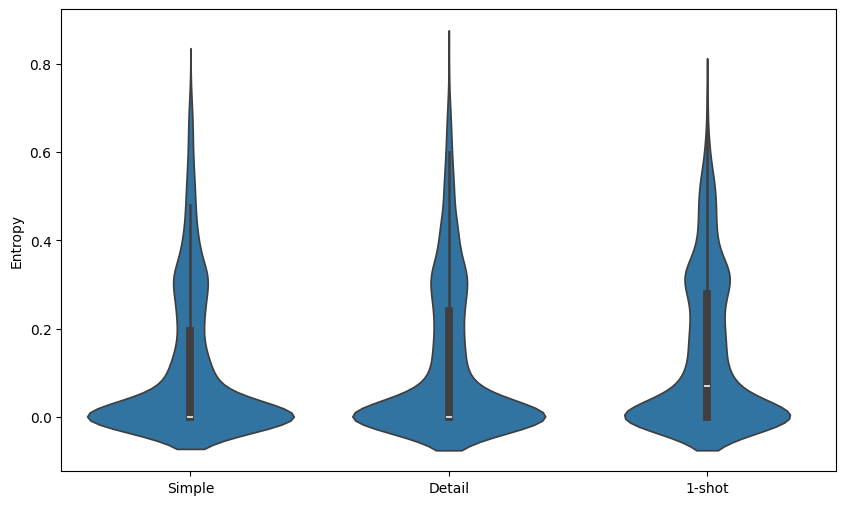

gpt-3.5 simple
Avg Entropy over samples: 0.09548433267873618,Std (over questions): 0.14011682503098755
gpt-3.5 instruct
Avg Entropy over samples: 0.09317439483965831,Std (over questions): 0.13816963600147408
gpt-3.5 fewshot
Avg Entropy over samples: 0.11963795806152479,Std (over questions): 0.1418947607421335


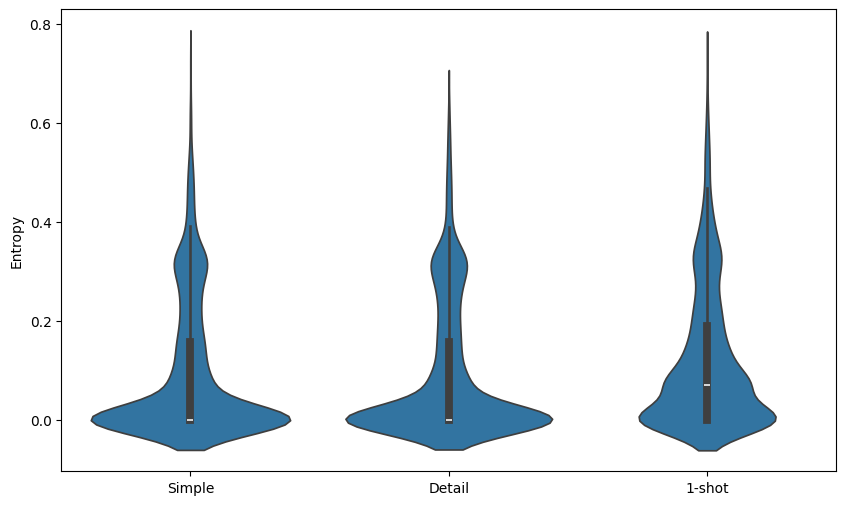

gpt-4o simple
Avg Entropy over samples: 0.04794549832080494,Std (over questions): 0.10599818085782504
gpt-4o instruct
Avg Entropy over samples: 0.045262583087053346,Std (over questions): 0.10060810928667752
gpt-4o fewshot
Avg Entropy over samples: 0.04603101966436327,Std (over questions): 0.1006963586935772


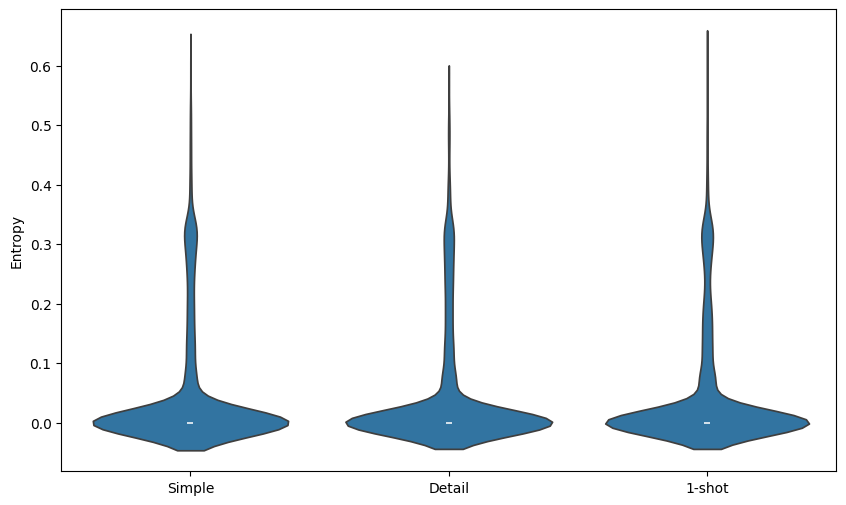

In [6]:
for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []
    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)
    
        data.append((em, prompt_type))
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    ax =sns.violinplot(x='Label', y='Values', data=df, split=False)
    plt.xlabel(None)
    ax.set_xticks(np.arange(3)) # <--- set the ticks first
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.ylabel('Entropy')
    plt.show()

In [7]:
if not os.path.exists(Path(results_folder, 'paper_figures')):
    os.makedirs(Path(results_folder, 'paper_figures'))
    
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

dataset="WoS"

figsize=(7.5,4.5)
n_samples, n_classes = len(samples), len(class_labels)

for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        TVD_matrix_per_class = print_consistency(sample_ids,
                                       prompt_type,
                                       llm,
                                       Q,
                                       temp_question,
                                       A,
                                       temp_answer,
                                       class_labels,
                                       results_folder)
    
        for c, TVD_matrix in enumerate(TVD_matrix_per_class):
            data.append((TVD_matrix.reshape(-1), prompt_type))
            
            c_name = class_labels[c]

            # plt.figure(figsize=(figsize[0]+1, figsize[0]))
            # ax = sns.heatmap(TVD_matrix, cbar_kws={'orientation': 'horizontal'})
            # plt.xlabel("Sample ID",fontsize=26)
            # plt.ylabel("Sample ID",fontsize=26)
            # # Adjust the layout to make room for the colorbar
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_matrix_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            # #plt.show()

            # sns.histplot(np.reshape(TVD_matrix, -1),
            #                         bins=20, stat='probability', kde=False, color='#3274A1', alpha=1.)
            # plt.xlabel(r"$C_y(x,x')$")
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_hist_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            # #plt.show()
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # # Plot the violin plot
    # plt.figure(figsize=figsize)  # Adjust the figure size if needed
    # ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    # plt.xlabel(None)
    # ax.set_xticks(np.arange(3)) # <--- set the ticks first
    # ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    # plt.ylim(0, 1)
    # plt.ylabel('Consistency')
    # plt.tight_layout()
    # plt.savefig(Path(results_folder, 'paper_figures',
    #         f'consistency_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    # plt.show()

llama3 simple
Prompt type: simple
Avg consistency over classes: 0.4786805779165326,Std consistency over classes: 0.466437479695531
llama3 instruct
Prompt type: instruct
Avg consistency over classes: 0.4807089324130723,Std consistency over classes: 0.4721985124981115
llama3 fewshot
Prompt type: fewshot
Avg consistency over classes: 0.46768516055570325,Std consistency over classes: 0.47272975676865053
mixtral simple
Prompt type: simple
Avg consistency over classes: 0.482574187888206,Std consistency over classes: 0.4245869827714795
mixtral instruct
Prompt type: instruct
Avg consistency over classes: 0.4693436839378965,Std consistency over classes: 0.416864775290604
mixtral fewshot
Prompt type: fewshot
Avg consistency over classes: 0.47254674805284486,Std consistency over classes: 0.4014672328428214
gpt-3.5 simple
Prompt type: simple
Avg consistency over classes: 0.48230538950099633,Std consistency over classes: 0.43041445156833447
gpt-3.5 instruct
Prompt type: instruct
Avg consistency ove

In [ ]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    errorbar_fig = plt.figure(figsize=figsize)

    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)

        sens_per_class = sensitivity_per_class(sample_ids,
                                               prompt_type,
                                               llm,
                                               Q,
                                               temp_question,
                                               A,
                                               temp_answer,
                                               class_labels,
                                               results_folder)

        # Add error bars (standard deviation)
        plt.figure(errorbar_fig)
        if prompt_type == 'instruct':
            label = 'Detail'
        elif prompt_type == 'fewshot':
            label = '1-shot'
        else:
            label = 'Simple'

        sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
        sens_per_class_mean = np.nan_to_num(sens_per_class_mean)
        sens_per_class_std = np.array([np.array(sens_per_class[c]).std() for c in range(len(class_labels))])
        sens_per_class_std = np.nan_to_num(sens_per_class_std)
        # plt.errorbar(np.arange(len(class_labels)), sens_per_class_mean, yerr=sens_per_class_std, fmt='-o',  solid_capstyle='projecting', capsize=5, label=label)
        plt.plot(sens_per_class_mean, label=label, marker='o', markersize=8)
        plt.ylabel('Sensitivity')
        plt.xticks(np.arange(len(class_labels)),
                            class_labels,
                            rotation='vertical')      
        plt.legend()
        
        data.append((em, prompt_type))

        plt.figure(errorbar_fig)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_class_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=figsize)  # Adjust the figure size if needed
    ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.xlabel(None)
    plt.ylabel('Sensitivity')
    # Setting the y-axis limits to cut off values below 0
    plt.ylim(0, None)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    plt.show()

In [ ]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

Q = 30
A = 1  # MUST stay 1
temp_answer = 0.


data = []
errorbar_fig = plt.figure(figsize=figsize)
    
for temp_question in temp_questions:
    
    for llm in ['llama3', 'mixtral']:
        
        for prompt_type in ['simple', 'instruct', 'fewshot']:
            
            em = print_test_sensitivity_over_samples(sample_ids,
                                            prompt_type,
                                            llm,
                                            Q,
                                            temp_question,
                                            A,
                                            temp_answer,
                                            class_labels,
                                            results_folder)
    
    
            # Add error bars (standard deviation)
            plt.figure(errorbar_fig)
            if prompt_type == 'instruct':
                label = 'Detail'
            elif prompt_type == 'fewshot':
                label = '1-shot'
            else:
                label = 'Simple'
    
            
            data.append((em.mean(), label, llm, int(temp_question/0.25)))
            
        
        
# Create a DataFrame from the expanded data
df = pd.DataFrame(data, columns=['Sensitivity', 'Strategy', 'LLM', 'Temperature'])
print(df)
# Plot the violin plot
plt.figure(figsize=figsize)  # Adjust the figure size if needed
ax = sns.lineplot(x='Temperature', y='Sensitivity', hue='LLM', style='Strategy', data=df)
ax.set_xticks(np.arange(5)) # <--- set the ticks first
ax.set_xticklabels([r'$0.$', r'$0.25$', r'$0.50$', r'$0.75$', r'$1.$'])
# Setting the y-axis limits to cut off values below 0
plt.ylim(0, None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.575))
plt.tight_layout()
plt.savefig(Path(results_folder, 'paper_figures',
            f'sensitivity_vs_temperature_{dataset}_{Q}_{A}_{temp_answer}.pdf'))
plt.show()

In [ ]:
for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder,
                                        noise_amount=1.)


In [ ]:
if not os.path.exists(Path(results_folder, 'paper_figures')):
    os.makedirs(Path(results_folder, 'paper_figures'))
    
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

dataset="TREC"
figsize=(7.5,4.5)
n_samples, n_classes = len(samples), len(class_labels)

for llm in ['llama3', 'mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        TVD_matrix_per_class = print_consistency(sample_ids,
                                       prompt_type,
                                       llm,
                                       Q,
                                       temp_question,
                                       A,
                                       temp_answer,
                                       class_labels,
                                       results_folder,
                                       noise_amount=1.)